In [32]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time 
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, make_scorer
from sklearn import svm, datasets
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPool1D, Dropout, Activation, Input, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from keras.models import Sequential

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
df_original = pd.read_csv('/content/gdrive/My Drive/DataSet/tweet_emotions.csv', encoding='windows-1252')

In [7]:
df = df_original.copy()

In [8]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [9]:
df.count()

tweet_id     40000
sentiment    40000
content      40000
dtype: int64

In [10]:
df.head(5)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [11]:
df = df.loc[:,['sentiment','content']]

In [12]:
df.head(2)

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...


In [13]:
df['sentiment'] = df['sentiment'].str.lower()

In [14]:
df.isnull().sum()

sentiment    0
content      0
dtype: int64

In [15]:
df.shape

(40000, 2)

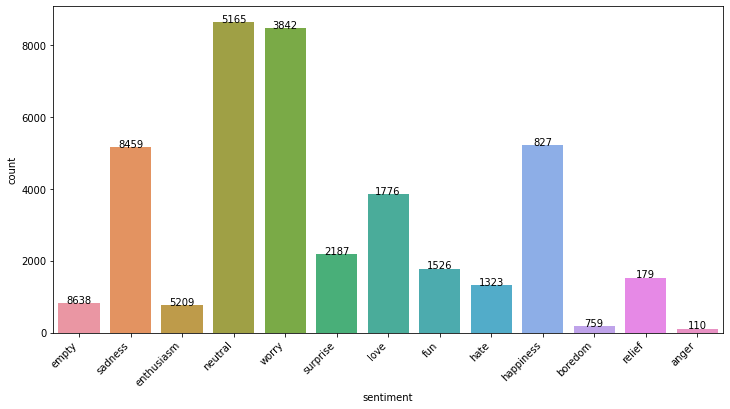

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax = sns.countplot(x='sentiment', data=df)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, height + 0.1, df['sentiment'].value_counts()[i], ha='center')
    i+=1

In [17]:
#removing class if any has a value 1
df = df.groupby('sentiment').filter(lambda x : len(x)>1)

#removing stopwords
stop = stopwords.words('english')
df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#removing urls
df['content'] = df['content'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

#removing HTML Tags
def remove_tags(string):
    result = re.sub('<.*?>', '', string)
    return result
df['content'] = df['content'].apply(lambda cw : remove_tags(cw))

#removing '\n' in the code
df['content'] = df['content'].replace('\n', ' ', regex=True)

#removing punctuations
punctuation = '''!()-[]{};:'"\,<>/?@#$%^&*~'''
def remove_punctuations(text):
    for punc in punctuation:
        text = text.replace(punc, '')
    return text
df['content'] = df['content'].apply(remove_punctuations)

#removing digits
df['content'] = df['content'].str.replace('\d+', '')

In [18]:
df.head(5)

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,Layin n bed headache ughhhh...waitin call...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants hang friends SOON
4,neutral,dannycastillo We want trade someone Houston ti...


In [19]:
#lemmitization
# from nltk.stem import WordNetLemmatizer
# from nltk import word_tokenize

WNlemma = nltk.WordNetLemmatizer()


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def pre_process_with_pos_tag(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if len(t)>2]
    tokens = [WNlemma.lemmatize(t, get_wordnet_pos(pos_tag(word_tokenize(t))[0][1])) for t in tokens]
    text_after_process = " ".join(tokens)
    return text_after_process

In [20]:
df['content'] = df['content'].apply(pre_process_with_pos_tag)

In [21]:
df.head(5)

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin bed headache ughhhh ... waitin call ...
2,sadness,funeral ceremony ... gloomy friday ...
3,enthusiasm,want hang friend soon
4,neutral,dannycastillo want trade someone houston ticke...


In [22]:
#Analysing the words in the content column
results = set()
df['content'].str.lower().str.split().apply(results.update)
print(results)

{'homelesscrisis', 'paycheck', 'mingin', 'jessiemona', 'momdukes', 'httptwitpic.comk', 'indiagovt', 'fatigue', 'rigid', 'httpplurk.compwyza', 'minireunion', 'khp', 'stillll', 'katherine', 'gealbhan_beag', 'shanzer', 'httptinyurl.comrexc', 'lemongrass', 'fashionismylife', 'doombug', 'ilonaaaa', 'stephreayy', 'chasesanders', 'gtown', 'httpwww.google.co.in', 'heel', 'breathing', 'alchemuse', 'bromeliad', 'berkscub', 'julio', 'havin', 'qiuqius', 'pourmecoffee', 'dayuummm', 'interfere', 'cbenton', 'ecomonday', 'lynne_lyons', 'hannahbananalee', 'yummmm', 'crystal_haze', 'press', 'beijingboyce', 'ashton', 'naman', 'patbrough', 'heatherofficial', 'framianne', 'trader', 'stressor', 'minority', 'exploit', 'zoopedup', 'retrogrrl', 'determines', 'broadband', 'sebiunouva', 'stripclub', 'httpwww.eabeauty.net', 'hahahahahahahahahahahaha', 'linkedin', 'copycars', 'troy', 'stellarbeam', 'hals', 'finalizer', 'address.quot', 'givee', 'stink', 'httptwitpic.comvld', 'baha', 'nkotbworshiper', 'midsomerlover

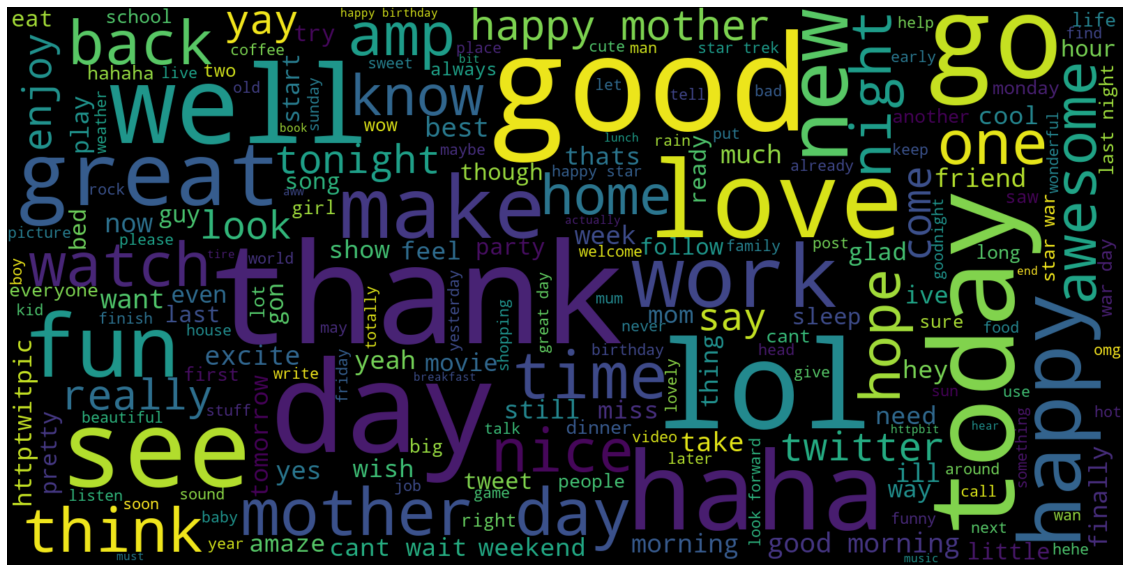

In [23]:
#wordcloud
class_label_0 = df[df['sentiment'] =='happiness']
string_0 = []
for t in class_label_0.content:
    string_0.append(t)
string_0 = pd.Series(string_0).str.cat(sep=' ')
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(string_0)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
x_all = df['content']
y_all = df['sentiment']

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, stratify=y_all, test_size=0.25, random_state=42)

In [26]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [27]:
le = preprocessing.LabelEncoder()
yy_train = le.fit_transform(y_train)

In [28]:
le1 = preprocessing.LabelEncoder()
yy_test = le1.fit_transform(y_test)

In [29]:
max_words = 10000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

tok_test = Tokenizer(num_words=max_words)
tok_test.fit_on_texts(x_test)
sequences_test = tok.texts_to_sequences(x_test)
sequences_matrix_test = pad_sequences(sequences_test, maxlen=max_len)

In [37]:
model = Sequential()
model.add(Input(name='input', shape=[max_len]))
model.add(Embedding(max_words, 50,input_length=max_len))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(LSTM(300))
model.add(Dense(df.sentiment.nunique(), activation='relu'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 50)           500000    
                                                                 
 dropout_3 (Dropout)         (None, 150, 50)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 146, 64)           16064     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 36, 64)           0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 300)               438000    
                                                                 
 dense_3 (Dense)             (None, 13)                3913      
                                                      

In [38]:
start_time= time.time()
history = model.fit(sequences_matrix, yy_train, epochs=5, batch_size=256, validation_split=0.2, verbose=1)
print("___ %s seconds ---" % (time.time() - start_time))

Epoch 1/5
94/94 [==============================] - 16s 24ms/step - loss: 3.3567 - accuracy: 0.2026 - val_loss: 2.5683 - val_accuracy: 0.2495
Epoch 2/5
94/94 [==============================] - 2s 17ms/step - loss: 2.5245 - accuracy: 0.2314 - val_loss: 2.3467 - val_accuracy: 0.2647
Epoch 3/5
94/94 [==============================] - 2s 18ms/step - loss: 2.3778 - accuracy: 0.2527 - val_loss: 2.4098 - val_accuracy: 0.2543
Epoch 4/5
94/94 [==============================] - 2s 18ms/step - loss: 2.4195 - accuracy: 0.2169 - val_loss: 2.4951 - val_accuracy: 0.2917
Epoch 5/5
94/94 [==============================] - 2s 18ms/step - loss: 2.3299 - accuracy: 0.3098 - val_loss: 2.4854 - val_accuracy: 0.3065
___ 42.651678800582886 seconds ---


In [40]:
print("accuracy of training data is - ", model.evaluate(sequences_matrix, yy_train)[1]*100, "%")
print("accuracy of testing data is - ", model.evaluate(sequences_matrix_test, yy_test)[1]*100, "%")

938/938 [==============================] - 4s 4ms/step - loss: 2.2342 - accuracy: 0.3655
accuracy of training data is -  36.5533322095871 %
313/313 [==============================] - 1s 4ms/step - loss: 2.5202 - accuracy: 0.2977
accuracy of testing data is -  29.769998788833618 %


In [41]:
y_pred = model.predict(sequences_matrix_test)

In [42]:
y_classes = y_pred.argmax(axis=-1)

In [43]:
y_classes

array([12,  8,  5, ..., 12,  8,  8])

In [44]:
yy_test

array([ 8,  9, 12, ...,  4,  5, 10])

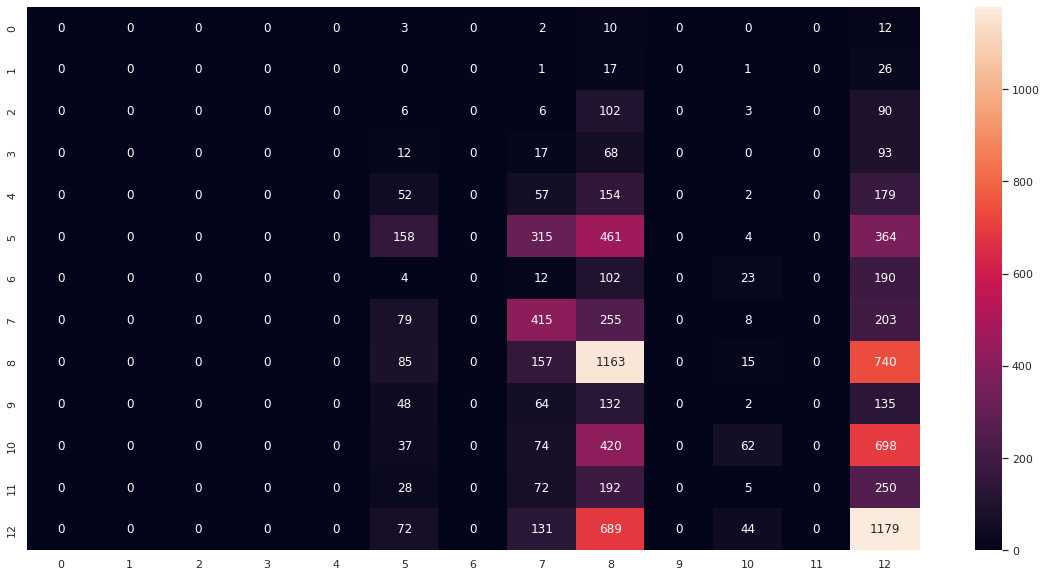

In [47]:
cf_matrix = confusion_matrix(yy_test, y_classes)
fig, ax = plt.subplots(figsize=(20,10))
sns.set(rc={'figure.figsize':(7,4)})
sns.heatmap(cf_matrix, annot=True, fmt='g')